# This notebook supports the creation of overview tables for experiments on the MNIST dataset.

Organize imports, set constants, and load result files.

In [9]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from ast import literal_eval
import os
import yaml
import json
from pathlib import Path

voting_name = 'stats_votings.csv'
teachers_name = "stats_teachers.csv"


def read_yaml(yaml_path):
    with open(yaml_path, 'r') as stream:
        return yaml.safe_load(stream)


HOME = os.environ["HOME"]

BASE_YAML_PATH = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_5_paper_submission/"
BASE_YAML_PATH = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_6_reviewer_response"

DATA_DIR = f"{HOME}/datadrive_individualized_pate/reviewer_response/round_2/"


def get_config_from_experiment_name(experiment_name,
                                    verbose=False,
                                    BASE_YAML_PATH=BASE_YAML_PATH):
    # get the epsilons
    # get the algo
    # get the distribution

    # step 1 : find the yaml and open it
    # step 2 : extra the info
    base_path = Path(BASE_YAML_PATH)
    paths = list(base_path.glob(f"**/{experiment_name}.yaml"))
    if len(paths) != 1:
        raise Exception(
            f"{experiment_name} - Unexpected number of paths - {len(paths)}")
    if verbose:
        print(paths)
    return read_yaml(paths[0])


def get_relevant_data_from_config(config):
    """ get algo, epsilons, distributions from config"""
    algo, epsilons = list(config["pate"]["budgets"].items())[0]
    epsilons = epsilons[0]  # its a list of lists, for some reason
    distributions = config["pate"]["distributions"][0][0]
    return algo, epsilons, distributions


def get_cost_curve(experiment_name):
    """ """
    OUT_PATH = os.path.join(DATA_DIR, experiment_name)
    df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))
    cost_curve = json.loads(df_v["costs_curve"].iloc[-1])
    return cost_curve


def get_data_frame(experiment_name, DATA_DIR=DATA_DIR):
    """ """
    OUT_PATH = os.path.join(DATA_DIR, experiment_name)
    return pd.read_csv(os.path.join(OUT_PATH, voting_name))


def get_labels_generated_from_cost_curve(cost_curve, epsilons):
    """ """
    return sum(
        np.array([
            under_budget(cost_curve[i], epsilons)
            for i in range(len(cost_curve))
        ]))


def get_labels_generated(experiment_name,
                         config_path,
                         epsilons,
                         DATA_DIR=DATA_DIR):
    """ """

    OUT_PATH = os.path.join(DATA_DIR, experiment_name)
    # baseline
    with open(config_path, 'r') as stream:
        config = yaml.safe_load(stream)
    cost_curve = get_cost_curve(experiment_name)

    labels_answered = sum(
        np.array([
            under_budget(cost_curve[i], epsilons)
            for i in range(len(cost_curve))
        ]))
    #grouped_labels_answered = []
    #if isinstance(cost_curve[0], list):
    #    print(cost_curve[0])
    #    for j in range(len(cost_curve[0])):
    #        print(j)
    #        grouped_labels_answered.append(sum(np.array([cost_curve[i][j]< epsilons[i][j] for i in range(len(cost_curve))])))
    return labels_answered  #, grouped_labels_answered


def under_budget(costs, max_epsilons):
    """ returns bool if all costs are under budget"""

    return all([costs[i] < max_epsilons[i] for i in range(len(costs))])


def get_algo_name(exp_name):
    names = {
        "upsample": "upsampling",
        "weight": "weighting",
        "vanish": "vanishing",
        "pate": "pate"
    }
    for name in names.keys():
        if name in exp_name:
            return names[name]

In [10]:
def plot_costs(cost_curve, cost_curve_b, epsilons):
    plt.figure(figsize=(10, 10))
    plt.title(f"{experiment}", fontsize=18)
    x_range = min(len(cost_curve), 2000)

    c1 = "mediumpurple"
    c2 = "blue"

    labels_answered = sum(
        np.array([
            under_budget(cost_curve[i], epsilons)
            for i in range(len(cost_curve))
        ]))
    labels_answered_b = sum(
        np.array([
            under_budget(cost_curve_b[i], epsilons)
            for i in range(len(cost_curve_b))
        ]))
    labels_answered1 = sum(
        np.array(
            [cost_curve[i][0] < epsilons[0] for i in range(len(cost_curve))]))

    plt.axvline(x=labels_answered1, c=c1)
    plt.axhline(y=epsilons[0], color=c1, linestyle='-')
    plt.axvline(x=labels_answered_b, c="tab:gray")

    if len(cost_curve[0]) > 1:
        labels_answered2 = sum(
            np.array([
                cost_curve[i][1] < epsilons[1] for i in range(len(cost_curve))
            ]))
        plt.axvline(x=labels_answered2, c=c2)
        plt.plot([np.array(cost_curve[i][1]) for i in range(labels_answered)],
                 "-",
                 c=c2,
                 label=f"{algo_name} (high)")  #, labels = ("1", "2", "3"))
        plt.plot([np.array(cost_curve[i][1]) for i in range(x_range)],
                 ":",
                 c=c2)  #, labels = ("1", "2", "3"))
        plt.axhline(y=epsilons[1], color=c2, linestyle='-')

    if len(cost_curve[0]) > 2:
        labels_answered3 = sum(
            np.array([
                cost_curve[i][2] < epsilons[2] for i in range(len(cost_curve))
            ]))
        plt.axvline(x=labels_answered3, c='g')
        plt.plot([np.array(cost_curve[i][2]) for i in range(labels_answered)],
                 "-",
                 c="g")  #, labels = ("1", "2", "3"))
        plt.plot([np.array(cost_curve[i][2]) for i in range(x_range)],
                 ":",
                 c="g")  #, labels = ("1", "2", "3"))
        plt.axhline(y=epsilons[2],
                    color='g',
                    linestyle='-',
                    label=f"eps = {epsilons[2]}")

    plt.plot([np.array(cost_curve[i][0]) for i in range(labels_answered)],
             "-",
             c=c1,
             label=f"{algo_name} (low)")
    plt.plot([np.array(cost_curve[i][0]) for i in range(x_range)], ":", c=c1)

    ##  PATE plots
    plt.plot([np.array(cost_curve_b[i]) for i in range(labels_answered_b)],
             "-",
             c="tab:gray",
             label="pate")  #, labels = ("1", "2", "3"))
    plt.plot([
        np.array(cost_curve_b[i]) for i in range(min(len(cost_curve_b), 2000))
    ],
             ":",
             c="tab:gray")  #, labels = ("1", "2", "3"))

    plt.ylabel("Privacy Budget", fontsize=18)
    plt.xlabel("Labels Answered", fontsize=18)
    plt.legend(fontsize=12)
    plt.show()

In [11]:
epsilons_ = [1., 2., 3.]
epsilons_2 = [np.around(np.log(2), 2), np.around(np.log(8), 2)]
pate_epsilons = epsilons_

experiments = [
    "weight", "vanish", "mnist_upsample_2", "adam_test",
    "mnist_upsample_row_2", "upsample_figure_2"
]
experiments = ["upsample_figure_2"]

experiments = [
    #"mnist_pate_row_2__2",
    #"mnist_upsample_row_2__2",
    #"mnist_vanish_row_2__2",
    "mnist_weight_row_2__2",
    #"weight",
    "adam_test"
]

experiments = ["vanish", "mnist_vanish_row_2__2"]

#experiments = ["mnist_weight_row_1__reweighted", "mnist_weight_row_2__reweighted"]

yaml_base_path = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_5_paper_submission/"
DATA_DIR = f"{HOME}/datadrive_individualized_pate/reviewer_response/round_2/"


In [12]:
pate_config_path = os.path.join(yaml_base_path, "mnist_pate_row_1.yaml")

df_vb = pd.read_csv(
    os.path.join(DATA_DIR, "mnist_pate_row_1__exp_3", voting_name))

with open(pate_config_path, 'r') as stream:
    pate_config = yaml.safe_load(stream)
cost_curve_b = json.loads(df_vb["costs_curve"].iloc[0])

labels_answered_b = sum(
    np.array([
        under_budget(cost_curve_b[i], pate_epsilons)
        for i in range(len(cost_curve_b))
    ]))

print(f"PATE - labels_answered: {labels_answered_b}")


FileNotFoundError: [Errno 2] No such file or directory: '/code/individualized-pate/individualized_pate/experiment_plans/set_6_reviewer_response/svhn_table_1/mnist_pate_row_1.yaml'

In [20]:
experiment_groups = {
    #    "mnist_row_1" : {},
    #    "mnist_row_2" : {},
    "svhn_row_1": {},
    "svhn_row_2": {}
}

experiments = []

for group_name, exp_groups in experiment_groups.items():
    dataset_name = group_name.split("_")[0]
    row = group_name.split("_")[-1]
    for e_name in ["pate", "vanish", "upsample", "weight"]:

        exp_groups[e_name] = {}

        for i in [0, 1, 2, 3, 4, 5, 6, 7]:
            exp_groups[e_name][
                f"{dataset_name}_{e_name}_row_{row}__exp_{i}"] = 0


In [ ]:
results = {}

DATA_DIR = f"{HOME}/datadrive_individualized_pate/reviewer_response/round_2/"
DATA_DIR = f"{HOME}/code/data/out/"
for exp_group_name, exp_group in experiment_groups.items():
    # mnist_row_1
    dataset_name = exp_group_name.split("_")[0]
    yaml_base_path = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_6_reviewer_response/{dataset_name}_table_1"
    print(dataset_name)
    for group_name in exp_group.keys():
        # upsample

        experiments = list(exp_group[group_name].keys())
        print(f"\t {group_name}")
        print(experiments)

        for experiment in experiments:
            algo_name = get_algo_name(experiment)
            yaml_filename = experiment[:-len("__exp_3")]
            yaml_name = f"{yaml_filename}.yaml"

            config = get_config_from_experiment_name(yaml_filename)
            algo, epsilons, distributions = get_relevant_data_from_config(
                config)
            config_path = os.path.join(yaml_base_path, yaml_name)

            if algo not in results:
                results[algo_name] = []
            try:
                labels_answered = get_labels_generated(experiment, config_path,
                                                       epsilons)
            except Exception as e:
                print(e)
                continue

            OUT_PATH = os.path.join(DATA_DIR, experiment)
            df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))

            # experiment = f"{experiment}" if "mnist" in experiment else f"mnist_{experiment}"

            print(f"epsilons : {epsilons}")

            print("-------")
            print(f"{experiment} - labels_answered: {labels_answered}")
            # log it in the dictionary
            exp_group[group_name][experiment] = labels_answered

            plotting = False
            if plotting:
                cost_curve = get_cost_curve(experiment_name)
                epsilons = epsilons_2 if len(cost_curve[0]) == 2 else epsilons_

                # PLOT VOTING MECHANISM VS LABEL COUNT

                #for i, labels_answered_group in enumerate(labels_answered_groups):
                #    print(f"{experiment} - labels_answered ({i}): {labels_answered_group}")
                print(
                    f"{experiment} - {algo}: accuracy: {df_v['accuracy'].mean()}"
                )
                plot_costs(cost_curve, cost_curve_b, epsilons)


# exp_groups_row_2

In [ ]:
##
## Generate figure for figure 2
##


def under_budget(costs, max_epsilons):
    """ returns bool if all costs are under budget"""
    return all([costs[i] < max_epsilons[i] for i in range(len(costs))])


epsilons = [np.around(np.log(2), 2), np.around(np.log(8), 2)]
pate_epsilons = epsilons_2

voting_name = 'stats_votings.csv'
DATA_DIR = f"{HOME}/datadrive_individualized_pate/"
yaml_base_path = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_5_paper_submission/"
BASELINE_PATH = f"{DATA_DIR}/pate/"

#
# baseline pate
#
pate_config_path = os.path.join(yaml_base_path, "mnist_pate.yaml")
df_vb = pd.read_csv(os.path.join(BASELINE_PATH, voting_name))
with open(pate_config_path, 'r') as stream:
    pate_config = yaml.safe_load(stream)
cost_curve_b = json.loads(df_vb["costs_curve"].iloc[0])
labels_answered_b = sum(
    np.array([
        under_budget(cost_curve_b[i], epsilons)
        for i in range(len(cost_curve_b))
    ]))
##

#
# upsampling
#
experiment = "upsample_figure_2"
algo_name = "upsampling"
yaml_name = f"mnist_{experiment}.yaml"
config_path = os.path.join(yaml_base_path, yaml_name)
OUT_PATH = os.path.join(DATA_DIR, experiment)

#
# configs
#
with open(config_path, 'r') as stream:
    config = yaml.safe_load(stream)
algo = list(config["pate"]["budgets"].keys())[0]
distributions = config["pate"]["distributions"][0][0]

#
# labels answered
#
df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))
cost_curve = json.loads(df_v["costs_curve"].iloc[0])

labels_answered = sum(
    np.array([
        under_budget(cost_curve[i], epsilons) for i in range(len(cost_curve))
    ]))
labels_answered1 = sum(
    np.array([cost_curve[i][0] < epsilons[0] for i in range(len(cost_curve))]))
labels_answered2 = sum(
    np.array([cost_curve[i][1] < epsilons[1] for i in range(len(cost_curve))]))

##
## plots
##

c1 = "mediumpurple"  #"mediumpurple"
c2 = "blue"  #"blue"
pate_c = "tab:gray"

hor_line_alpha = 0.6
vert_line_alpha = 0.75

hor_line_style = "dashdot"
vert_line_style = "-"

big_font = 20
small_font = 18

plt.figure(figsize=(15, 8))
plt.ylim(0, top=3.5)

# hor lines

plt.axhline(y=epsilons[0],
            color=c1,
            linestyle=hor_line_style,
            alpha=hor_line_alpha)
plt.axhline(y=epsilons[1],
            color=c2,
            linestyle=hor_line_style,
            alpha=hor_line_alpha)
plt.text(1350, epsilons[0] + .025, 'low budget : log(2)', fontsize=small_font)
plt.text(1350, epsilons[1] + .025, 'high budget : log(8)', fontsize=small_font)

# vertical lines:
plt.plot((labels_answered1, labels_answered1), (0, epsilons[0]),
         c=c1,
         linestyle=vert_line_style,
         alpha=vert_line_alpha)
plt.plot((labels_answered2, labels_answered2), (0, epsilons[1]),
         c=c2,
         linestyle=vert_line_style,
         alpha=vert_line_alpha)
# pate vertical lines
plt.plot((labels_answered_b, labels_answered_b), (0, epsilons[0]),
         c=pate_c,
         linestyle=vert_line_style,
         alpha=vert_line_alpha)

# pate stopping points
plt.scatter((labels_answered_b - 1), (cost_curve_b[labels_answered_b - 1][0]),
            c="orange",
            label="pate stopping point")

x_range = min(len(cost_curve), 2000)
plt.plot([np.array(cost_curve[i][1]) for i in range(labels_answered)],
         "-",
         c=c2,
         label=f"{algo_name} (high)")  #, labels = ("1", "2", "3"))
plt.plot([np.array(cost_curve[i][1]) for i in range(x_range)], ":",
         c=c2)  #, labels = ("1", "2", "3"))

plt.plot([np.array(cost_curve[i][0]) for i in range(labels_answered)],
         "-",
         c=c1,
         label=f"{algo_name} (low)")
plt.plot([np.array(cost_curve[i][0]) for i in range(x_range)], ":", c=c1)

# stopping points
plt.scatter((labels_answered, labels_answered),
            (cost_curve[labels_answered][0], cost_curve[labels_answered][1]),
            c="red",
            label="upsampling stopping point")

#
##  PATE plots
#
plt.plot([np.array(cost_curve_b[i]) for i in range(labels_answered_b)],
         "-",
         c=pate_c,
         label="pate")
plt.plot(
    [np.array(cost_curve_b[i]) for i in range(min(len(cost_curve_b), 2000))],
    ":",
    c=pate_c)

# labels
plt.xticks(fontsize=small_font)
plt.yticks(fontsize=small_font)

plt.ylabel("Privacy Budget", fontsize=big_font)
plt.xlabel("Number of Generated Labels", fontsize=big_font)
plt.legend(fontsize=small_font)

save_path = f"{HOME}/assets/upsampling_demo.pdf"
print(save_path)
plt.savefig(save_path)

plt.show()

#
# text

print(f"PATE - labels_answered: {labels_answered_b}")
print(f"PATE - accuracy: {df_vb['accuracy'].mean()}")
print("-------")
print(f"{experiment} - labels_answered: {labels_answered}")
print(f"{experiment} - labels_answered (0): {labels_answered1}")
print(f"{experiment} - labels_answered (1):  {labels_answered2}")
print(f"{experiment} - labels_answered (2): {labels_answered3}")
print(f"{experiment} - {algo}: accuracy: {df_v['accuracy'].mean()}")

/code/individualized-pate/individualized_pate/experiment_plans/set_5_paper_submission/mnist_vanish_table_4__3.yaml
[0.75, 0.25]
[0.63402, 0.63402]
epsilons:
[0.6931471805599453, 2.0794415416798357]
-------
epsilons: 
[ln(2), ln(8)]
 table%
0.75% - 0.25% 
		mnist_vanish_table_4__3 - labels_answered: 28
		PATE - labels_answered: 257


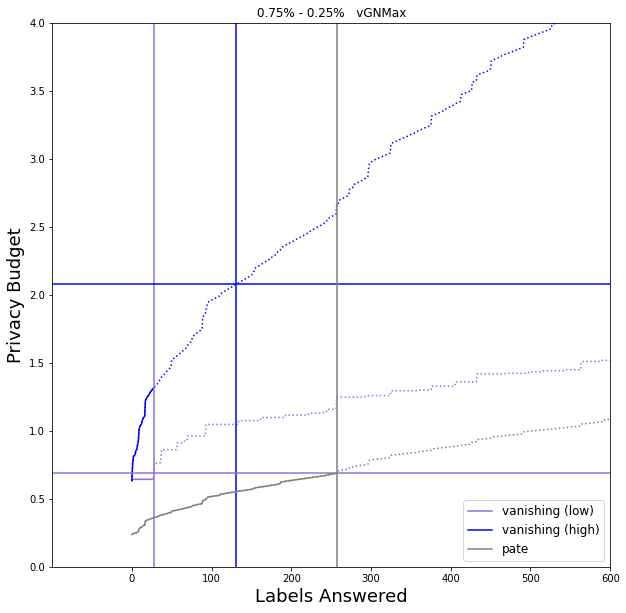

In [469]:
##
## Table 4
##

epsilons_ = [1., 2., 3.]
epsilons_2 = [np.around(np.log(2), 2), np.around(np.log(8), 2)]

pate_epsilons = epsilons_

experiments = [

    #mnist_weight_75_25__ln4",
    #mnist_weight_75_25__ln4__2",
    #mnist_weight_50_50__ln4",
    #"mnist_weight_25_75__ln4",
    "mnist_weight_75_25__ln8",
    "mnist_weight_75_25__ln8__2",
    #"mnist_weight_50_50__ln8",
    #"mnist_weight_25_75__ln8",
    "mnist_weight_75_25__ln16",
    #"mnist_weight_50_50__ln16",
    #"mnist_weight_25_75__ln16",
]

voting_name = 'stats_votings.csv'
teachers_name = "stats_teachers.csv"

yaml_base_path = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_5_paper_submission/"
DATA_DIR = f"{HOME}/datadrive_individualized_pate/"

BASELINE_PATH = f"{DATA_DIR}/pate/"

pate_config_path = os.path.join(yaml_base_path, "mnist_pate.yaml")
df_vb = pd.read_csv(os.path.join(BASELINE_PATH, voting_name))
with open(pate_config_path, 'r') as stream:
    pate_config = yaml.safe_load(stream)
cost_curve_b = json.loads(df_vb["costs_curve"].iloc[0])

#yaml_base_path = os.path.join(yaml_base_path,"table_4_weighting")

DATA_DIR = f"{HOME}/code/data/out/"

experiments = ["mnist_weight_50_50__ln8__3"]
experiments = ["mnist_vanish_row_2__2",
               "mnist_vanish_row_2__3"]  # beep boop baap
experiments = ["mnist_vanish_table_4__3"]  # beep boop baap

for experiment in experiments:
    algo_name = get_algo_name(experiment)
    yaml_name = f"{experiment}.yaml"
    config_path = os.path.join(yaml_base_path, yaml_name)

    print(config_path)
    OUT_PATH = os.path.join(DATA_DIR, experiment)
    df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))

    experiment = f"{experiment}"

    # baseline
    with open(config_path, 'r') as stream:
        config = yaml.safe_load(stream)

    algo = list(config["pate"]["budgets"].keys())[0]
    distributions = config["pate"]["distributions"][0][0]
    print(distributions)
    #epsilons = sorted(json.loads(df_v["eps_short"].iloc[0]))
    #epsilons = np.log(np.array([2,16]))
    epsilons = epsilons_
    epsilons = [np.log(2), np.log(8)]

    cost_curve = json.loads(df_v["costs_curve"].iloc[-1])
    print(cost_curve[0])
    print("epsilons:")
    print(epsilons)

    labels_answered = sum(
        np.array([
            under_budget(cost_curve[i], epsilons)
            for i in range(len(cost_curve))
        ]))

    labels_answered1 = sum(
        np.array(
            [cost_curve[i][0] < epsilons[0] for i in range(len(cost_curve))]))
    labels_answered2 = sum(
        np.array(
            [cost_curve[i][1] < epsilons[1] for i in range(len(cost_curve))]))
    #labels_answered3 = sum(np.array([cost_curve[i][2] < epsilons[1] for i in range(len(cost_curve))]))

    print("-------")
    #print(f"epsilons : {epsilons}")
    exponents = np.around(np.exp(np.array(epsilons)), 0)
    print(f"epsilons: \n[ln({int(exponents[0])}), ln({int(exponents[1])})]")
    name = experiment[len("mnist_weight_"):len("mnist_weight_25_75")]
    print(" " + "% -".join(name.split("_")) + "%")
    title = f"{distributions[0]}% - {distributions[1]}% "  # "- {distributions[2]}%"
    print(title)
    title += "  " + algo
    #print(f"{experiment} - {algo}: number of votes: {df_v['n_votings'].mean()}")
    print(f"\t\t{experiment} - labels_answered: {labels_answered}")

    # pate
    labels_answered_b = sum(
        np.array([
            under_budget(cost_curve_b[i], epsilons)
            for i in range(len(cost_curve_b))
        ]))
    print(f"\t\tPATE - labels_answered: {labels_answered_b}")
    #print(f"PATE - accuracy: {df_vb['accuracy'].mean()}")

    c1 = "mediumpurple"
    c2 = "blue"

    plt.figure(figsize=(10, 10))
    #plt.title(f"{experiment}", fontsize=18)
    plt.title(title)
    x_range = min(len(cost_curve), 2000)
    plt.plot([np.array(cost_curve[i][0]) for i in range(labels_answered)],
             "-",
             c=c1,
             label=f"{algo_name} (low)")
    plt.plot([np.array(cost_curve[i][0]) for i in range(x_range)], ":", c=c1)
    if len(cost_curve[0]) > 1:
        plt.plot([np.array(cost_curve[i][1]) for i in range(labels_answered)],
                 "-",
                 c=c2,
                 label=f"{algo_name} (high)")  #, labels = ("1", "2", "3"))
        plt.plot([np.array(cost_curve[i][1]) for i in range(x_range)],
                 ":",
                 c=c2)  #, labels = ("1", "2", "3"))

    if len(cost_curve[0]) > 2:
        plt.plot([np.array(cost_curve[i][2]) for i in range(labels_answered)],
                 "-",
                 c="g")  #, labels = ("1", "2", "3"))
        plt.plot([np.array(cost_curve[i][2]) for i in range(x_range)],
                 ":",
                 c="g")  #, labels = ("1", "2", "3"))

    plt.axvline(x=labels_answered1, c=c1)
    plt.axvline(x=labels_answered2, c=c2)
    if len(cost_curve[0]) > 2:
        plt.axvline(x=labels_answered3, c='g')

    #plt.axhline(y=epsilons[0], color='r', linestyle='-', label = f"Most Private (eps = {epsilons[0]})")
    #hack -hard code legends
    plt.axhline(y=epsilons[0], color=c1, linestyle='-')
    if len(epsilons) > 1:
        #plt.axhline(y=epsilons[1], color='b', linestyle='-', label = f"Least Private (eps = {epsilons[1]})")
        # hack -hard code legends
        plt.axhline(y=epsilons[1], color=c2, linestyle='-')

    if len(epsilons) > 2:
        plt.axhline(y=epsilons[2],
                    color='g',
                    linestyle='-',
                    label=f"eps = {epsilons[2]}")

    ##  PATE plots
    plt.plot([np.array(cost_curve_b[i]) for i in range(labels_answered_b)],
             "-",
             c="tab:gray",
             label="pate")  #, labels = ("1", "2", "3"))
    plt.plot([
        np.array(cost_curve_b[i]) for i in range(min(len(cost_curve_b), 2000))
    ],
             ":",
             c="tab:gray")  #, labels = ("1", "2", "3"))

    plt.axvline(x=labels_answered_b, c="tab:gray")
    #(0.1, 0.2, 0.5, 0.3)

    plt.ylabel("Privacy Budget", fontsize=18)
    plt.xlabel("Labels Answered", fontsize=18)
    plt.legend(fontsize=12)
    plt.xlim(right=600)
    plt.ylim((0, 4))

    plt.show()

    #print(f"PATE - number of votes: {df_vb['n_votings'].mean()}")


In [191]:
# generate student accuracy table
configs = [
    "mnist_weight_row_1__reweighted",
    "mnist_weight_row_2__reweighted",

    #"vanish", computing now
    #"mnist_vanish_row_2__2", computing now
    "upsample_figure_2",
    "mnist_upsample_row_2__3",

    #"mnist_pate_row_2__2",
]

name_mapping_dict = {
    "mnist_weight_row_1__reweighted": "weight row 1",
    "mnist_weight_row_2__reweighted": "weight row 2",

    #"vanish", computing now
    #"mnist_vanish_row_2__2", computing now
    "upsample_figure_2": "upsample row 1",
    "mnist_upsample_row_2__3": "upsample row 2",
}
BASE_YAML_PATH = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_5_paper_submission/table_2_students"
for config_name in configs:
    c = get_config_from_experiment_name(config_name,
                                        BASE_YAML_PATH=BASE_YAML_PATH)
    students_csv = f"{HOME}/datadrive_individualized_pate/{config_name}/stats_students.csv"
    df_s = pd.read_csv(students_csv)
    print(
        f"Student accuracy : {name_mapping_dict[config_name]} - {np.mean(df_s['test_accuracy'])}"
    )

    #students_csv = f"{HOME}/datadrive_individualized_pate/upsample_plot_1/stats_students.csv"
    #students_csv2 = f"{HOME}/datadrive_individualized_pate/upsample_plot_5/stats_students.csv"
    #pate_csv = f"{HOME}/datadrive_individualized_pate/mnist_weight_row_1__reweighted/stats_students.csv"

    #print(f"pate  - {np.mean(df_s['test_accuracy'])}")
    #df_s = pd.read_csv(students_csv2)
    #print(f"upsampling - 5x - {np.mean(df_s['test_accuracy'])}")


Student accuracy : weight row 1 - 95.02000000000001
Student accuracy : weight row 2 - 95.06000000000002
Student accuracy : upsample row 1 - 78.38
Student accuracy : upsample row 2 - 92.97999999999999


In [53]:
voting_name = 'stats_votings.csv'
teachers_name = "stats_teachers.csv"

yaml_base_path = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_5_paper_submission/upsample_plot/"
DATA_DIR = f"{HOME}/datadrive_individualized_pate/"


def compute_weighted_ratio(epsilons, distributions):
    if len(epsilons) != len(distributions):
        raise Exception("groups len and distributions length not the same")
    if sum(distributions) != 1:
        raise Exception("distribution does not sum to 1")
    return sum(np.array(epsilons) * np.array(distributions))


compute_weighted_ratio([16, 4], [.75, .25])


In [269]:
DATA_DIR = f"{HOME}/datadrive_individualized_pate/"
#DATA_DIR = f"{HOME}/code/data/out"

upsample_experiments = [
    "upsample_plot_25_75__1",
    "upsample_plot_25_75__2",
    "upsample_plot_25_75__3",  # redo this one
    "upsample_plot_25_75__4",
    "upsample_plot_25_75__5",
    "upsample_plot_25_75__6",
    "upsample_plot_25_75__7",  # redo this one 
    "upsample_plot_25_75__8",
    "upsample_plot_1",
    "upsample_plot_2",
    "upsample_plot_3",
    "upsample_plot_4",
    "upsample_plot_5",
    "upsample_plot_6",
    "upsample_plot_7",
    "upsample_plot_75_25__1",
    "upsample_plot_75_25__2",
    "upsample_plot_75_25__3",
    "upsample_plot_75_25__4",
    "upsample_plot_75_25__5",
    "upsample_plot_75_25__6",
    "upsample_plot_75_25__7",
    "upsample_plot_75_25__8",
]

weight_and_vanish_experiments = [
    "vanish_plot_25_75__2",
    #"vanish_plot_50_50__2", # need to make this one next
    #"vanish_plot_75_25__2", # making this now on nic2 (voting ~ 15 min)
    "weight_plot_25_75__2",
    #"weight_plot_50_50__2", # just started - running on equus (~1 hour) (start - 6 pm)
    "weight_plot_75_25__2",  # done
]
extras = [
    "vanish_plot_25_75__2",
    "vanish_plot_25_75__3",
    "vanish_plot_25_75__4",
    "vanish_plot_25_75__5",
    "vanish_plot_25_75__6",
    "vanish_plot_25_75__7",
    "vanish_plot_50_50__2",
    "vanish_plot_50_50__3",
    #"vanish_plot_50_50__4",
    "vanish_plot_75_25__2",
    "vanish_plot_75_25__3",
    #"weight_plot_1",
    "weight_plot_75_25__2",
    "weight_plot_75_25__3",
    "weight_plot_75_25__4",
    "weight_plot_75_25__5",
    "weight_plot_75_25__6",
    "weight_plot_75_25__7",
    "weight_plot_75_25__8",
]


def get_algo_name(exp_name):
    names = {
        "upsample": "upsampling",
        "weight": "weighting",
        "vanish": "vanishing",
        "pate": "pate"
    }
    for name in names.keys():
        if name in exp_name:
            return names[name]


In [ ]:
e = 3


def get_cost_curve_for_eps(df, e=1):
    return json.loads(
        df[df["eps_short"] == f"[1.0, {e}.0]"].iloc[-1]['costs_curve'])


In [ ]:
from collections import defaultdict

results_50_50 = defaultdict(lambda: [])

results_25_75 = defaultdict(lambda: [])
results_75_25 = defaultdict(lambda: [])

## just upsampling
##

for i, experiment_name in enumerate(upsample_experiments):
    #print(i)
    algo_name = get_algo_name(experiment_name)
    yaml_name = f"{experiment_name}.yaml"

    config = get_config_from_experiment_name(experiment_name)
    algo, epsilons, distributions = get_relevant_data_from_config(config)
    weighted_ratio = compute_weighted_ratio(epsilons, distributions)
    if algo not in results:
        results[algo_name] = []
    try:
        labels_answered = get_labels_generated(experiment_name, config_path,
                                               epsilons)
    except Exception as e:
        print(e)
        continue
    if distributions == [.5, .5]:
        results_50_50[algo_name].append((weighted_ratio, labels_answered))
    elif distributions == [.25, .75]:
        results_25_75[algo_name].append((weighted_ratio, labels_answered))
    elif distributions == [.75, .25]:
        results_75_25[algo_name].append((weighted_ratio, labels_answered))
    else:
        print("UHOH")
        print(distributions)

In [ ]:
weight_and_vanish_experiments = [  #"weight_plot_25_75__all", # looks good
    #"weight_plot_50_50__all2" # need to rerun
    #"weight_plot_75_25__all" # need to rerun
]

weight_and_vanish_experiments = [
    #"vanish_plot_25_75__all2",
    #"vanish_plot_50_50__all2",

    #"weight_plot_50_50__all2",
    #"vanish_plot_75_25__all" , # this one worked for some reason
    #"weight_plot_25_75__all",
    "weight_plot_25_75__2",
    "weight_plot_25_75__3",
    "weight_plot_25_75__4",
    "weight_plot_25_75__5",
    "weight_plot_25_75__6",
    "weight_plot_25_75__7",
    "weight_plot_25_75__8",
    "weight_plot_25_75__9",
    "weight_plot_25_75__10",
    "weight_plot_25_75__11",
    "weight_plot_25_75__12",
    "weight_plot_50_50__2",
    "weight_plot_50_50__3",
    "weight_plot_50_50__4",
    "weight_plot_50_50__5",
    "weight_plot_50_50__6",
    "weight_plot_50_50__7",
    "weight_plot_75_25__2",
    "weight_plot_75_25__3",
    "weight_plot_75_25__4",
    "weight_plot_75_25__5",
    "weight_plot_75_25__6",
    "weight_plot_75_25__7",
    "weight_plot_75_25__8",
    "weight_plot_75_25__9",
    "weight_plot_75_25__10",
    "weight_plot_75_25__11",
    "weight_plot_75_25__12",
    "weight_plot_75_25__13",
    "weight_plot_75_25__14",
    "weight_plot_75_25__15",

    ###"weight_plot_75_25__all", # just kicked off
]

DATA_DIR1 = f"{HOME}/datadrive_individualized_pate/"
DATA_DIR2 = f"{HOME}/code/data/out"
for i, experiment_name in enumerate(weight_and_vanish_experiments):
    #print(i)
    algo_name = get_algo_name(experiment_name)
    yaml_name = f"{experiment_name}.yaml"
    try:
        config = get_config_from_experiment_name(experiment_name)
    except:
        continue
    algo, epsilons, distributions = get_relevant_data_from_config(config)
    try:
        df = get_data_frame(experiment_name, DATA_DIR=DATA_DIR1)
    except:
        try:
            df = get_data_frame(experiment_name, DATA_DIR=DATA_DIR2)
        except:
            print(f"nope on {experiment_name}")
            continue

    if algo not in results:
        results[algo_name] = []

    for epsilon_2 in range(1, 8 + 1):
        epsilons = [1., epsilon_2 * 1.]
        try:
            cost_curve = get_cost_curve_for_eps(df, e=epsilon_2)
        except:
            #print(f"failed for {epsilon_2}")
            continue
        plot = False
        if plot:
            #plot_costs(cost_curve, cost_curve, [1.,epsilon_2])

            plt.plot(cost_curve)
            plt.axhline(1.)
            plt.axhline(epsilon_2)

        labels_answered = get_labels_generated_from_cost_curve(
            cost_curve, epsilons)

        print(
            f"{algo_name} {distributions} eps (1., {epsilon_2}): {labels_answered}"
        )
        weighted_ratio = compute_weighted_ratio(epsilons, distributions)
        if distributions == [.5, .5]:
            results_50_50[algo_name].append((weighted_ratio, labels_answered))
        elif distributions == [.25, .75]:
            results_25_75[algo_name].append((weighted_ratio, labels_answered))
        elif distributions == [.75, .25]:
            results_75_25[algo_name].append((weighted_ratio, labels_answered))
        else:
            print("UHOH")
            print(distributions)

/assets/weighted_ratio_of_generated_labels.pdf


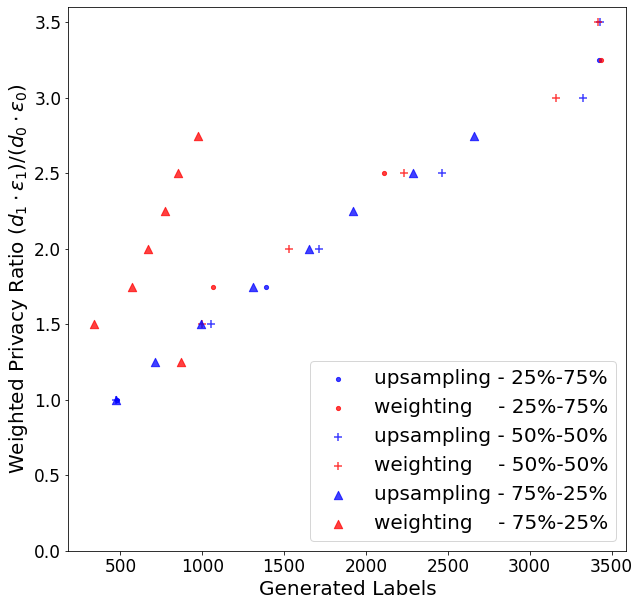

In [444]:
plt.figure(figsize=(10, 10))
big_font = 20
small_font = 17
markersize = 70

#plt.title("Generated Labels vs Ratio between epsilons", fontsize = 16)
flip = True
if flip:
    #plt.xlim(0, 3300)
    plt.ylim((0., 3.6))
    plt.xlabel("Generated Labels", fontsize=big_font)
    plt.ylabel(
        "Weighted Privacy Ratio $(d_1 \cdot \epsilon_1) / (d_0 \cdot \epsilon_0)$",
        fontsize=big_font)

else:
    plt.xlim((0., 3.6))
    plt.ylabel("Generated Labels", fontsize=big_font)
    plt.xlabel(
        "Weighted Epsilon Ratio $(d_1 \cdot \epsilon_1) / (d_0 \cdot \epsilon_0)$",
        fontsize=big_font)

colors = {"weighting": "r", "upsampling": "blue", "vanishing": "brown"}
markers = {"weighting": "^", "upsampling": "+", "vanishing": "."}
alpha = {"weighting": .75, "upsampling": .75, "vanishing": .5}

skip_vanish = True

for algo, ratioed_labels_generated in results_25_75.items():
    if skip_vanish and algo == "vanishing":
        continue
    x, y = list(zip(*ratioed_labels_generated))
    if flip:
        x, y = y, x
    algo_name = algo
    if "weight" in algo:
        algo_name += "   "
    plt.scatter(x,
                y,
                label=f"{algo_name} - 25%-75%",
                marker=".",
                c=colors[algo],
                alpha=alpha[algo],
                s=markersize)
    #plt.scatter(x,y , label = f"{algo} - 25%-75%", marker =markers[algo], c = "b")

for algo, ratioed_labels_generated in results_50_50.items():
    if skip_vanish and algo == "vanishing":
        continue
    x, y = list(zip(*ratioed_labels_generated))
    if flip:
        x, y = y, x
    algo_name = algo
    if "weight" in algo:
        algo_name += "   "
    plt.scatter(x,
                y,
                label=f"{algo_name} - 50%-50%",
                marker="+",
                c=colors[algo],
                alpha=alpha[algo],
                s=markersize)
    #plt.scatter(x,y , label = f"{algo} - 50%-50%", marker =markers[algo], c = "r")

for algo, ratioed_labels_generated in results_75_25.items():
    if skip_vanish and algo == "vanishing":
        continue
    x, y = list(zip(*ratioed_labels_generated))
    if flip:
        x, y = y, x
    algo_name = algo
    if "weight" in algo:
        algo_name += "   "
    plt.scatter(x,
                y,
                label=f"{algo_name} - 75%-25%",
                marker="^",
                c=colors[algo],
                alpha=alpha[algo],
                s=markersize)
    #plt.scatter(x,y , label = f"{algo} - 75%-25%", marker =markers[algo], c = "g")
# x0 x1 , y0 y1
#plt.plot((0 ,3400), (0.5, 3.5))
plt.legend(fontsize=big_font)
plt.xticks(fontsize=small_font)
plt.yticks(fontsize=small_font)

save_path = f"{HOME}/assets/weighted_ratio_of_generated_labels.pdf"
print(save_path)
plt.savefig(save_path)

plt.show()

#
# note: the reason why you see plateaus earlier, is because for some models the lower group
#


In [404]:
results_75_25

defaultdict(<function __main__.<lambda>()>,
            {'upsampling': [(1.0, 473),
              (1.25, 711),
              (1.5, 991),
              (1.75, 1312),
              (2.0, 1649),
              (2.25, 1918),
              (2.5, 2286),
              (2.75, 2659)],
             'weighting': [(1.25, 870),
              (1.5, 337),
              (1.75, 571),
              (2.0, 670),
              (2.25, 775),
              (2.5, 852)]})

2


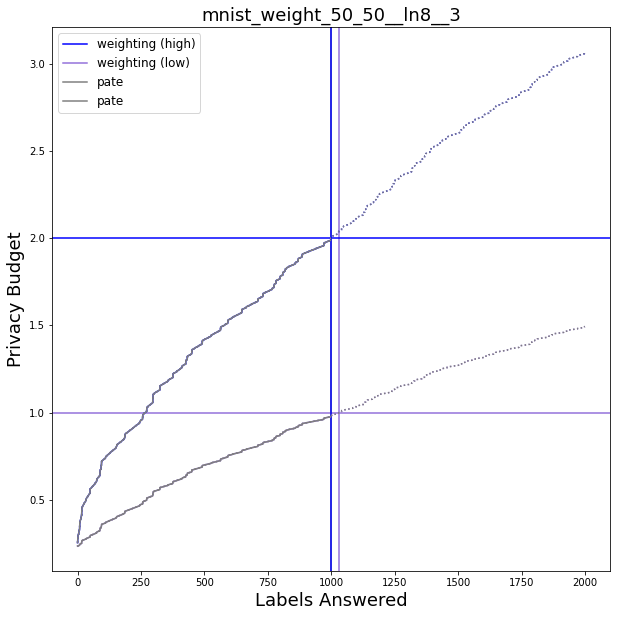

3


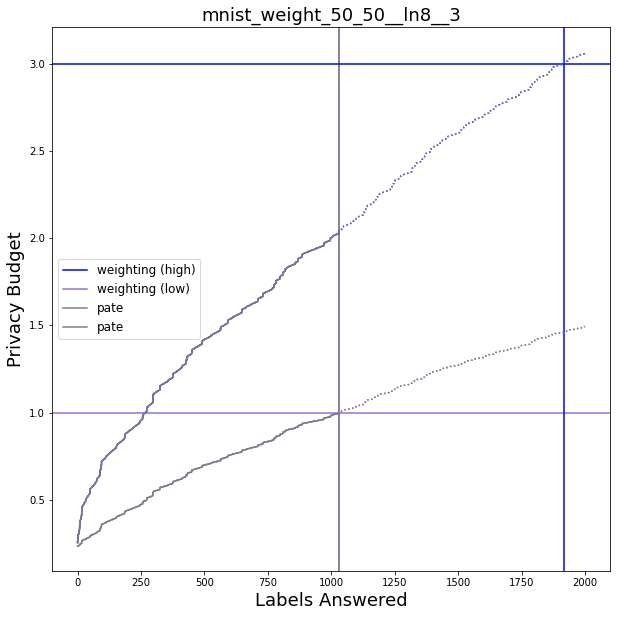

4


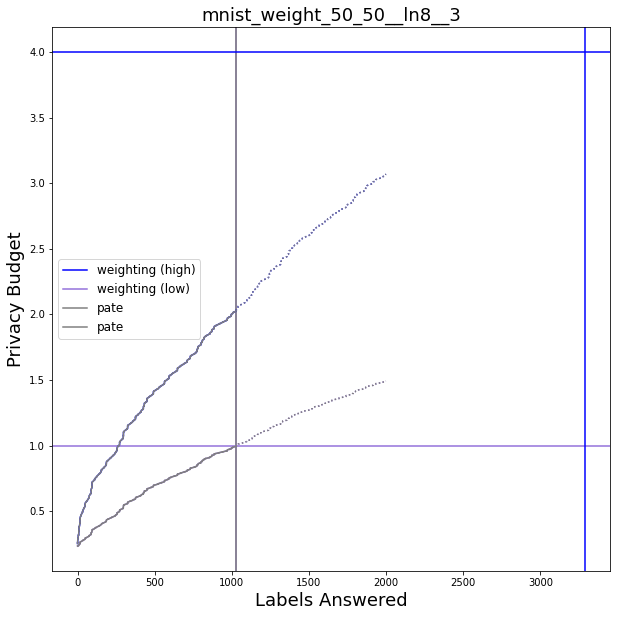

5


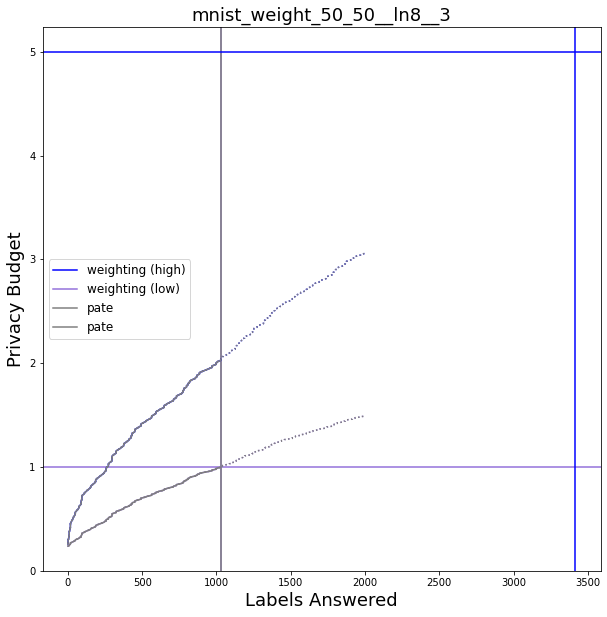

In [331]:
name = "weight_plot_50_50__all2"

OUT_PATH = os.path.join(DATA_DIR2, name)
with open(config_path, 'r') as stream:
    config = yaml.safe_load(stream)

df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))

pd.set_option("display.max_columns", None)

e = 3


def get_cost_curve_for_eps(df, e=1):
    return json.loads(
        df[df["eps_short"] == f"[1.0, {e}.0]"].iloc[-1]['costs_curve'])


for e in [2, 3, 4, 5]:
    print(e)
    plot_costs(get_cost_curve_for_eps(df, e=e),
               get_cost_curve_for_eps(df, e=e), [1., e])


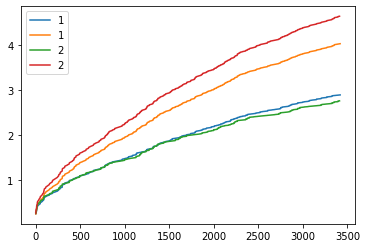

In [229]:
name = "vanish_plot_75_25__2"

OUT_PATH = os.path.join(DATA_DIR, name)
with open(config_path, 'r') as stream:
    config = yaml.safe_load(stream)

df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))
cost_curve = json.loads(df_v["costs_curve"].iloc[0])

labels_answered = sum(
    np.array([
        under_budget(cost_curve[i], epsilons) for i in range(len(cost_curve))
    ]))

#labels_answered
cost_curve
#df_v
plt.plot(cost_curve, label="1")
#plt.show()

name = "vanish_plot_75_25__3"

OUT_PATH = os.path.join(DATA_DIR, name)
with open(config_path, 'r') as stream:
    config = yaml.safe_load(stream)

df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))
cost_curve = json.loads(df_v["costs_curve"].iloc[0])

labels_answered = sum(
    np.array([
        under_budget(cost_curve[i], epsilons) for i in range(len(cost_curve))
    ]))

#labels_answered
cost_curve
#df_v
plt.plot(cost_curve, label="2")
plt.legend()
plt.show()


In [45]:
list(zip(*weighted_labels_generated))

[(1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0),
 (492, 1046, 1621, 2277, 3328, 3382, 3395)]

In [76]:
eps_s = np.log(np.array([4, 8, 16]))
dists = ((.25, .75), (.5, .5), (.75, .25))

relative_weights = []
for dist in dists:
    ratio = dist[0] / dist[1]
    print(f"Ratio is {np.around(ratio)}")
    ws = []
    for eps in eps_s:

        w = ratio * (eps / (np.log(2) + eps))

        ws.append(np.around(w, 2))

    relative_weights.append(ws)
relative_weights = np.array(relative_weights).T
for ws in relative_weights:

    print(ws)

Ratio is 0.0
Ratio is 1.0
Ratio is 3.0
[0.22 0.67 2.  ]
[0.25 0.75 2.25]
[0.27 0.8  2.4 ]


In [202]:
res = {eps: [] for eps in epsilons}

for e in epsilons:
    for d in distributions:
        #data = df[(df['budgets_linear'] == str([CONSTANT * 1.0, CONSTANT * 1.0 * e])) &
        #          (df['distribution'] == str({'all': (1 - d, d)}))]
        data = df
        u = round(
            np.mean(data[data['collector'] == 'uGNMax']['accuracy']) * 100, 2)
        v = round(
            np.mean(data[data['collector'] == 'vGNMax']['accuracy']) * 100, 2)
        w = round(
            np.mean(data[data['collector'] == 'wGNMax']['accuracy']) * 100, 2)
        res[e].append((u, v, w))

print(algo)
print(experiment)
print('Table of average voting accuracy per personalization.\n')
print('average of baseline GNMax:', round(np.mean(df_vb['accuracy']) * 100, 2))

pd.DataFrame(res, index=distributions).T


uGNMax
upsample_2
Table of average voting accuracy per personalization.

average of baseline GNMax: 97.4


,0.34,0.43,0.23
1.0,"(97.24, nan, nan)","(97.24, nan, nan)","(97.24, nan, nan)"
2.0,"(97.24, nan, nan)","(97.24, nan, nan)","(97.24, nan, nan)"
3.0,"(97.24, nan, nan)","(97.24, nan, nan)","(97.24, nan, nan)"


In [203]:
res = {eps: [] for eps in epsilons}
for e in epsilons:
    for d in distributions:

        #data = df[(df['budgets_linear'] == str([CONSTANT * 1.0, CONSTANT * 1.0 * e])) &
        #          (df['distribution'] == str({'all': (1 - d, d)}))]
        data = df
        u = round(
            np.mean(data[data['collector'] == 'uGNMax']['n_votings']) * 100, 2)
        v = round(
            np.mean(data[data['collector'] == 'vGNMax']['n_votings']) * 100, 2)
        w = round(
            np.mean(data[data['collector'] == 'wGNMax']['n_votings']) * 100, 2)
        res[e].append((u, v, w))

print(experiment)

print(algo)
print('Table of average n_votings per personalization.\n')
print('average of baseline GNMax:',
      round(np.mean(df_vb['n_votings']) * 100, 2))
pd.DataFrame(res, index=distributions).T

upsample_2
uGNMax
Table of average n_votings per personalization.

average of baseline GNMax: 341620.0


,0.34,0.43,0.23
1.0,"(342140.0, nan, nan)","(342140.0, nan, nan)","(342140.0, nan, nan)"
2.0,"(342140.0, nan, nan)","(342140.0, nan, nan)","(342140.0, nan, nan)"
3.0,"(342140.0, nan, nan)","(342140.0, nan, nan)","(342140.0, nan, nan)"


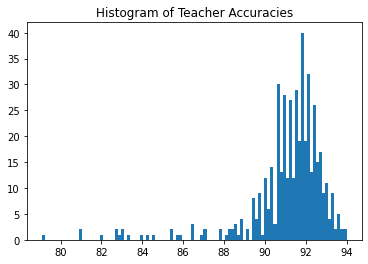

In [204]:
df_t

# TODO: plot histogram of teacher accuracies
plt.title("Histogram of Teacher Accuracies")
plt.hist(df_t["test_accuracy"], bins=100)
plt.show()

In [205]:
print('Statistics on voting accuracies (in %):')

va_min = round(np.min(df_v['accuracy']) * 100, 2)
va_max = round(np.max(df_v['accuracy']) * 100, 2)
va_avg = round(np.mean(df_v['accuracy']) * 100, 2)
va_std = round(np.std(df_v['accuracy']) * 100, 2)

bva_min = round(np.min(df_vb['accuracy']) * 100, 2)
bva_max = round(np.max(df_vb['accuracy']) * 100, 2)
bva_avg = round(np.mean(df_vb['accuracy']) * 100, 2)
bva_std = round(np.std(df_vb['accuracy']) * 100, 2)

print('min:', va_min)
print('max:', va_max)
print('avg:', va_avg)
print('std:', va_std)
print('\nbaselines:')
print('min:', bva_min)
print('max:', bva_max)
print('avg:', bva_avg)
print('std:', bva_std)

pd.set_option("display.max_columns", None)
print(df_v.columns)
df_v.head()

Statistics on voting accuracies (in %):
min: 97.15
max: 97.35
avg: 97.24
std: 0.08

baselines:
min: 97.3
max: 97.55
avg: 97.4
std: 0.09
Index(['Unnamed: 0', 'accuracy', 'n_votings', 'n_labels', 'alpha_curve',
       'ratios', 'avg_budget', 'avg_budget_linear', 'simple_budgets',
       'costs_curve', 'costs_curve_linear', 'aggregator', 'voting_seed',
       'seed', 'collector', 'eps_short', 'distribution', 'n_teachers', 'delta',
       'sigma', 'sigma1', 't'],
      dtype='object')


,Unnamed: 0,accuracy,n_votings,n_labels,alpha_curve,ratios,avg_budget,avg_budget_linear,simple_budgets,costs_curve,costs_curve_linear,aggregator,voting_seed,seed,collector,eps_short,distribution,n_teachers,delta,sigma,sigma1,t
0,0,0.9715,3397,2000,"[[50.0, 50.0, 50.0], [50.0, 50.0, 43.0], [50.0...","[20400, 25800, 13800]",2.166,8.721,"[1.0, 2.0, 3.0]","[[0.23533, 0.23936, 0.28765], [0.23569, 0.2437...","[[1.265, 1.27, 1.333], [1.266, 1.276, 1.388], ...",confident,0,9,uGNMax,"[1.0, 2.0, 3.0]","{'all': [0.34, 0.43, 0.23]}",473,0.00001,75.68,283.8,378.4
1,0,0.9725,3429,2000,"[[50.0, 50.0, 50.0], [50.0, 50.0, 43.0], [50.0...","[20400, 25800, 13800]",2.166,8.721,"[1.0, 2.0, 3.0]","[[0.23533, 0.23936, 0.28765], [0.23619, 0.2530...","[[1.265, 1.27, 1.333], [1.266, 1.288, 1.42], [...",confident,1,9,uGNMax,"[1.0, 2.0, 3.0]","{'all': [0.34, 0.43, 0.23]}",473,0.00001,75.68,283.8,378.4
2,0,0.9735,3431,2000,"[[50.0, 50.0, 50.0], [50.0, 50.0, 42.0], [50.0...","[20400, 25800, 13800]",2.166,8.721,"[1.0, 2.0, 3.0]","[[0.23557, 0.24516, 0.30169], [0.23594, 0.2495...","[[1.266, 1.278, 1.352], [1.266, 1.283, 1.411],...",confident,2,9,uGNMax,"[1.0, 2.0, 3.0]","{'all': [0.34, 0.43, 0.23]}",473,0.00001,75.68,283.8,378.4
3,0,0.9715,3415,2000,"[[50.0, 50.0, 50.0], [50.0, 50.0, 50.0], [50.0...","[20400, 25800, 13800]",2.166,8.721,"[1.0, 2.0, 3.0]","[[0.23527, 0.2362, 0.23775], [0.23564, 0.24061...","[[1.265, 1.266, 1.268], [1.266, 1.272, 1.337],...",confident,3,9,uGNMax,"[1.0, 2.0, 3.0]","{'all': [0.34, 0.43, 0.23]}",473,0.00001,75.68,283.8,378.4
4,0,0.9730,3428,2000,"[[50.0, 50.0, 50.0], [50.0, 50.0, 43.0], [50.0...","[20400, 25800, 13800]",2.166,8.721,"[1.0, 2.0, 3.0]","[[0.23534, 0.2399, 0.28972], [0.23571, 0.24431...","[[1.265, 1.271, 1.336], [1.266, 1.277, 1.391],...",confident,4,9,uGNMax,"[1.0, 2.0, 3.0]","{'all': [0.34, 0.43, 0.23]}",473,0.00001,75.68,283.8,378.4


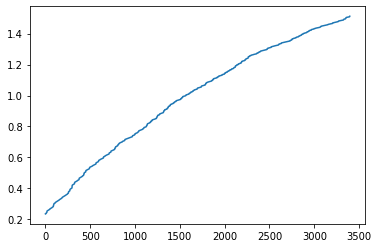

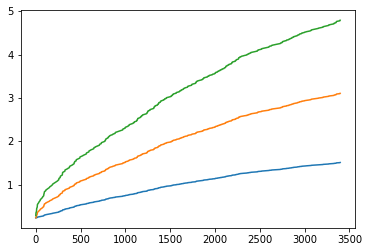

In [207]:
plt.plot([i[0] for i in cc])
#plt.plot([i[1] for i in cc])
#plt.plot([i[2] for i in cc])
plt.show()

plt.plot([i[0] for i in cc])
plt.plot([i[1] for i in cc])
plt.plot([i[2] for i in cc])
plt.show()

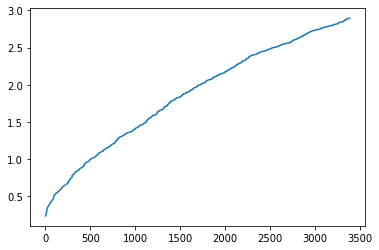

In [183]:
# PATE:
df_v["costs_curve"].iloc[0]
import json

cc = json.loads(df_vb["costs_curve"].iloc[0])

plt.plot([i[0] for i in cc])
#plt.plot([i[1] for i in cc])
#plt.plot([i[2] for i in cc])
plt.show()


In [143]:
df = df_s

epsilons = [2, 4, 8]
distributions = [0.25, 0.5, 0.75]

res = {
    2: [],
    4: [],
    8: [],
}
for e in epsilons:
    for d in distributions:
        data = df[
            (df['budgets_linear'] == str([CONSTANT * 1.0, CONSTANT * 1.0 * e]))
            & (df['distribution'] == str({'all': (1 - d, d)}))]
        t = round(np.mean(data['n_labels']), 2)
        u = round(np.mean(data[data['collector'] == 'uGNMax']['n_labels']), 2)
        v = round(np.mean(data[data['collector'] == 'vGNMax']['n_labels']), 2)
        w = round(np.mean(data[data['collector'] == 'wGNMax']['n_labels']), 2)
        res[e].append((u, v, w))

print('Table of average number of produced labels per personalization.\n')
for e in [1, 2, 4, 8]:
    x = math.log(CONSTANT * 1.0 * e)
    print(f'GNMax with budget {CONSTANT} * {e}:',
          round(np.mean(df_sb[df_sb['limit'] == f'({x},)']['n_labels']), 2))
pd.DataFrame(res, index=distributions).T

NameError: name 'df_s' is not defined

In [29]:
df = df_s

epsilons = [2, 4, 8]
distributions = [0.25, 0.5, 0.75]

res = {
    2: [],
    4: [],
    8: [],
}
for e in epsilons:
    for d in distributions:
        data = df[
            (df['budgets_linear'] == str([CONSTANT * 1.0, CONSTANT * 1.0 * e]))
            & (df['distribution'] == str({'all': (1 - d, d)}))]
        u = round(
            np.mean(data[data['collector'] == 'uGNMax']['test_accuracy']) *
            100, 2)
        v = round(
            np.mean(data[data['collector'] == 'vGNMax']['test_accuracy']) *
            100, 2)
        w = round(
            np.mean(data[data['collector'] == 'wGNMax']['test_accuracy']) *
            100, 2)
        res[e].append((u, v, w))

print('Table of average accuracy (in %) per personalization.\n')
for e in [1, 2, 4, 8]:
    x = math.log(CONSTANT * 1.0 * e)
    print(
        f'GNMax with budget {CONSTANT} * {e}:',
        round(
            np.mean(df_sb[df_sb['limit'] == f'({x},)']['test_accuracy']) * 100,
            2))
pd.DataFrame(res, index=distributions).T

NameError: name 'df_s' is not defined

In [30]:
df = df_s

epsilons = [2, 4, 8]
distributions = [0.25, 0.5, 0.75]

res = {
    2: [],
    4: [],
    8: [],
}
for e in epsilons:
    for d in distributions:
        data = df[
            (df['budgets_linear'] == str([CONSTANT * 1.0, CONSTANT * 1.0 * e]))
            & (df['distribution'] == str({'all': (1 - d, d)}))]
        t = data['avg_budget'].iloc[0]
        res[e].append(
            round(np.mean(df_sb[df_sb['limit'] == str((t, ))]['n_labels']), 2))

print(
    'Table of average number of labels for non-personalized GNMax with average budget per personalization.\n'
)
pd.DataFrame(res, index=distributions).T

NameError: name 'df_s' is not defined

In [31]:
df = df_s

epsilons = [2, 4, 8]
distributions = [0.25, 0.5, 0.75]

res = {
    2: [],
    4: [],
    8: [],
}
for e in epsilons:
    for d in distributions:
        data = df[
            (df['budgets_linear'] == str([CONSTANT * 1.0, CONSTANT * 1.0 * e]))
            & (df['distribution'] == str({'all': (1 - d, d)}))]
        t = data['avg_budget'].iloc[0]
        res[e].append(
            round(
                np.mean(df_sb[df_sb['limit'] == str((t, ))]['test_accuracy']) *
                100, 2))

print(
    'Table of average accuracy (in %) for non-personalized GNMax with average budget per personalization.\n'
)
pd.DataFrame(res, index=distributions).T

NameError: name 'df_s' is not defined

In [ ]:
## Just in ccase:

epsilons_ = [1., 2., 3.]
epsilons_2 = [np.around(np.log(2), 2), np.around(np.log(8), 2)]
pate_epsilons = epsilons_

experiments = [
    "weight", "vanish", "mnist_upsample_2", "adam_test",
    "mnist_upsample_row_2", "upsample_figure_2"
]
experiments = ["upsample_figure_2"]

experiments = [
    #"mnist_pate_row_2__2",
    #"mnist_upsample_row_2__2",
    #"mnist_vanish_row_2__2",
    "mnist_weight_row_2__2",
    #"weight",
    "adam_test"
]

experiments = ["vanish", "mnist_vanish_row_2__2"]
#experiments = ["mnist_weight_row_1__reweighted", "mnist_weight_row_2__reweighted"]

yaml_base_path = f"{HOME}/code/individualized-pate/individualized_pate/experiment_plans/set_5_paper_submission/"
DATA_DIR = f"{HOME}/datadrive_individualized_pate/"

BASELINE_PATH = f"{DATA_DIR}/pate/"

pate_config_path = os.path.join(yaml_base_path, "mnist_pate.yaml")
df_vb = pd.read_csv(os.path.join(BASELINE_PATH, voting_name))
with open(pate_config_path, 'r') as stream:
    pate_config = yaml.safe_load(stream)
cost_curve_b = json.loads(df_vb["costs_curve"].iloc[0])

labels_answered_b = sum(
    np.array([
        under_budget(cost_curve_b[i], pate_epsilons)
        for i in range(len(cost_curve_b))
    ]))

print(f"PATE - labels_answered: {labels_answered_b}")

#DATA_DIR = f"{HOME}/code/data/out/"

for experiment in experiments:
    algo_name = get_algo_name(experiment)

    if "adam" in experiment or "mnist" in experiment:
        yaml_name = f"{experiment}.yaml"
    else:
        yaml_name = f"mnist_{experiment}.yaml"
    config_path = os.path.join(yaml_base_path, yaml_name)

    OUT_PATH = os.path.join(DATA_DIR, experiment)

    df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))

    experiment = f"{experiment}" if "mnist" in experiment else f"mnist_{experiment}"

    # baseline
    with open(config_path, 'r') as stream:
        config = yaml.safe_load(stream)

    algo = list(config["pate"]["budgets"].keys())[0]
    #epsilons = list(config["pate"]["budgets"].values())[0][0]
    distributions = config["pate"]["distributions"][0][0]
    # list(config["pate"]["budgets"].values())[0][0]

    cost_curve = json.loads(df_v["costs_curve"].iloc[0])

    if len(cost_curve[0]) == 2:

        epsilons = epsilons_2
    else:  #if len(cost_curve[0]) == 3:
        epsilons = epsilons_
    # PLOT VOTING MECHANISM VS LABEL COUNT
    print(f"epsilons : {epsilons}")

    labels_answered = sum(
        np.array([
            under_budget(cost_curve[i], epsilons)
            for i in range(len(cost_curve))
        ]))

    labels_answered1 = sum(
        np.array(
            [cost_curve[i][0] < epsilons[0] for i in range(len(cost_curve))]))
    if len(cost_curve[0]) > 1:
        labels_answered2 = sum(
            np.array([
                cost_curve[i][1] < epsilons[1] for i in range(len(cost_curve))
            ]))
    if len(cost_curve[0]) > 2:
        labels_answered3 = sum(
            np.array([
                cost_curve[i][2] < epsilons[2] for i in range(len(cost_curve))
            ]))

    c1 = "mediumpurple"
    c2 = "blue"

    plt.figure(figsize=(10, 10))
    plt.title(f"{experiment}", fontsize=18)
    x_range = min(len(cost_curve), 2000)
    plt.plot([np.array(cost_curve[i][0]) for i in range(labels_answered)],
             "-",
             c=c1,
             label=f"{algo_name} (low)")
    plt.plot([np.array(cost_curve[i][0]) for i in range(x_range)], ":", c=c1)
    if len(cost_curve[0]) > 1:
        plt.plot([np.array(cost_curve[i][1]) for i in range(labels_answered)],
                 "-",
                 c=c2,
                 label=f"{algo_name} (high)")  #, labels = ("1", "2", "3"))
        plt.plot([np.array(cost_curve[i][1]) for i in range(x_range)],
                 ":",
                 c=c2)  #, labels = ("1", "2", "3"))

    if len(cost_curve[0]) > 2:
        plt.plot([np.array(cost_curve[i][2]) for i in range(labels_answered)],
                 "-",
                 c="g")  #, labels = ("1", "2", "3"))
        plt.plot([np.array(cost_curve[i][2]) for i in range(x_range)],
                 ":",
                 c="g")  #, labels = ("1", "2", "3"))

    plt.axvline(x=labels_answered1, c=c1)
    plt.axvline(x=labels_answered2, c=c2)
    if len(cost_curve[0]) > 2:
        plt.axvline(x=labels_answered3, c='g')

    #plt.axhline(y=epsilons[0], color='r', linestyle='-', label = f"Most Private (eps = {epsilons[0]})")
    #hack -hard code legends
    plt.axhline(y=epsilons[0], color=c1, linestyle='-')
    if len(epsilons) > 1:
        #plt.axhline(y=epsilons[1], color='b', linestyle='-', label = f"Least Private (eps = {epsilons[1]})")
        # hack -hard code legends
        plt.axhline(y=epsilons[1], color=c2, linestyle='-')

    if len(epsilons) > 2:
        plt.axhline(y=epsilons[2],
                    color='g',
                    linestyle='-',
                    label=f"eps = {epsilons[2]}")

    ##  PATE plots
    plt.plot([np.array(cost_curve_b[i]) for i in range(labels_answered_b)],
             "-",
             c="tab:gray",
             label="pate")  #, labels = ("1", "2", "3"))
    plt.plot([
        np.array(cost_curve_b[i]) for i in range(min(len(cost_curve_b), 2000))
    ],
             ":",
             c="tab:gray")  #, labels = ("1", "2", "3"))

    plt.axvline(x=labels_answered_b, c="tab:gray")
    #(0.1, 0.2, 0.5, 0.3)

    plt.ylabel("Privacy Budget", fontsize=18)
    plt.xlabel("Labels Answered", fontsize=18)
    plt.legend(fontsize=12)
    plt.show()

    #print(f"PATE - number of votes: {df_vb['n_votings'].mean()}")

    print("-------")
    #print(f"{experiment} - {algo}: number of votes: {df_v['n_votings'].mean()}")
    print(f"{experiment} - labels_answered: {labels_answered}")
    print(f"{experiment} - labels_answered (0): {labels_answered1}")
    if len(cost_curve[0]) > 1:
        print(f"{experiment} - labels_answered (1):  {labels_answered2}")
    if len(cost_curve[0]) > 2:
        print(f"{experiment} - labels_answered (2): {labels_answered3}")

    print(f"{experiment} - {algo}: accuracy: {df_v['accuracy'].mean()}")
